# 전체 프로세스 정리

## 1. 데이터 수집

- 날씨 데이터 (기상청)
 - 2016년 12월 ~ 추가 데이터 수집
 - Temperature, PrecipitationForm, PrecipitationProb, Humidity, WindSpeed, WindDirection, Cloud, Precipitation

- energy 데이터 (공공데이터포털)
 - 2016년 12월 ~ 추가 데이터 수집
 - dangjin_floating 제외 (2018년 이전 데이터 존재X)

- 태양의 고도 및 방위각 데이터 (한국천문연구원)
 - 2016년 12월 ~ 추가 데이터 수집
 - 방위각, 고도, 적경, 적위

## 2. 데이터 전처리

- 가장 최신의 예보를 바탕으로 선형보간
- 각 발전소별로 energy 결측치가 존재하는 날짜 제거

## 3. 피쳐 엔지니어링

- 각도와 시간을 나타내는 칼럼은 모두 sin, cos 값을 추가로 구함
- Temperature의 경우 계절과 시간을 기준으로 평균 Temperature를 추가로 구함

## 4. Model

- Causal Padding을 사용한 CNN1D 모델 구축
- feature selection과 추가 적인 feature engineering을 모두 모델에 맡기기 위해서 모든 feature를 사용함
- 시간에 대한 상관성을 합성곱으로 나타내고자 CNN1D 모델 구축
- 처음 부터 모델을 만드는 것은 컴퓨팅 파워와 시간 면에서 좋지 않다고 판단하여 다른 시계열 데이터에 좋은 성능을 보였던 모델을 기본 베이스로 조금 수정해서 사용
- 예측하고자 하는 시간을 기준으로 이전 3일치 데이터를 가지고 예측을 하는 방식으로 모델을 구성

## 5. 학습

- Train Data를 Random Sampling 하고 CV를 5로 학습
- 8 : 2로 Train과 Val Data를 나눠서 학습
- Loss의 경우 Metric과 유사한 MAE로 선택
- Optimization의 경우 RMSprop으로 선택(시계열의 경우 RMSprop이 조금 더 우수한 성능을 보임)
- Best Model의 경우 Val 기준으로 가장 Metric이 우수한 모델로 선택

## 6. 예측

- CV별 예측 값을 평균 내어 최종 예측값으로 활용
- CV별 예측 시에 학습이 제대로 안된 모델은 예측에서 제외
- Random Sampling의 효과로 CV별 모델이 서로 잘 맞추는 부분이 달라짐으로써 강건한 모델이 만들어짐


# OS 버전

Google Colaboratory GPU 사용

OS                   :	 Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic

Process information  :	 x86_64

Process Architecture :	 x86_64

RAM Size             :	 13(GB)

In [ ]:
import platform, psutil
 
def printOsInfo():
    print('OS                   :\t', platform.platform())

def printSystemInfor():
    print('Process information  :\t', platform.processor())
    print('Process Architecture :\t', platform.machine())
    print('RAM Size             :\t',str(round(psutil.virtual_memory().total / (1024.0 **3)))+"(GB)")

printOsInfo()
printSystemInfor()

OS                   :	 Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Process information  :	 x86_64
Process Architecture :	 x86_64
RAM Size             :	 13(GB)


# 조금 더 세밀한 예보 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Data/'

dangjin_fcst = pd.read_csv(PATHS + '당진데이터_완료_20210707.csv')
ulsan_fcst = pd.read_csv(PATHS + '울산데이터_완료_20210707.csv')

dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast_time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast_time'])

In [ ]:
def interpolate_df(df_, method='linear'):
  
    df = df_.copy()
    df['Forecast_time'] = pd.to_datetime(df['Forecast_time'])

    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    
    return new_df.interpolate(method=method)

In [ ]:
dangjin_interpolated = interpolate_df(dangjin_fcst, method='linear')
ulsan_interpolated = interpolate_df(ulsan_fcst, method='linear')

In [ ]:
dangjin_interpolated['hour'] = dangjin_interpolated['Forecast_time'].dt.hour
dangjin_interpolated['date'] = dangjin_interpolated['Forecast_time'].dt.date
dangjin_interpolated['month'] = dangjin_interpolated['Forecast_time'].dt.month
dangjin_interpolated['day'] = dangjin_interpolated['Forecast_time'].dt.day
dangjin_interpolated = dangjin_interpolated.fillna(0)

ulsan_interpolated['hour'] = ulsan_interpolated['Forecast_time'].dt.hour
ulsan_interpolated['date'] = ulsan_interpolated['Forecast_time'].dt.date
ulsan_interpolated['month'] = ulsan_interpolated['Forecast_time'].dt.month
ulsan_interpolated['day'] = ulsan_interpolated['Forecast_time'].dt.day
ulsan_interpolated = ulsan_interpolated.fillna(0)

# 피쳐 엔지니어링

In [ ]:
energy = pd.read_csv(PATHS + 'new_energy.csv')
energy['time'] = ulsan_interpolated[:len(energy)]['Forecast_time'].values
energy['time'] = pd.to_datetime(energy['time'])
energy['hour'] = energy['time'].dt.hour
energy['date'] = energy['time'].dt.date
energy['month'] = energy['time'].dt.month
energy['day'] = energy['time'].dt.day
energy = energy[:-1]

In [ ]:
energy_list = ['dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']

def get_energy_df(col):
  if 'dangjin' in col:
    _df = dangjin_interpolated.copy()
  else:
    _df = ulsan_interpolated.copy()

  _energy = energy.copy()
  
  null_idx = energy[energy[col].isna()]['time'].values

  floating = energy.groupby('date')[col].sum()
  zero_floating_idx = floating[floating == 0].index

  _df = _df[~_df['Forecast_time'].isin(null_idx)]
  _energy = _energy[~_energy['time'].isin(null_idx)]

  _df = _df[~_df['date'].isin(zero_floating_idx)]
  _energy = _energy[~_energy['date'].isin(zero_floating_idx)]

  _df = _df.reset_index(drop=True)
  _energy = _energy.reset_index(drop=True)
  cols = ['time', col]

  _df = pd.concat([_df, _energy[cols]], axis=1)

  return _df

In [ ]:
dangjin_floating_df = get_energy_df('dangjin_floating')
dangjin_warehouse_df = get_energy_df('dangjin_warehouse')
dangjin_df = get_energy_df('dangjin')
ulsan_df = get_energy_df('ulsan')

In [ ]:
def angle_to_cos(x):
    return np.cos(np.pi/180*(x-90))
    
def angle_to_sin(x):
    return np.sin(np.pi/180*(x+90))

def angle_to_dir(x):
    if pd.isnull(x):
        return np.nan
    elif x >= 22.5 and x <67.5:
        return 0
    elif x >= 67.5 and x < 112.5:
        return 1
    elif x >= 112.5 and x < 157.5:
        return 2
    elif x >= 157.5 and x < 202.5:
        return 3
    elif x >= 202.5 and x < 247.5:
        return 4
    elif x >= 247.5 and x < 292.5:
        return 5
    elif x >= 292.5 and x < 337.5:
        return 6
    elif x >= 337.5 or x < 22.5:
        return 7

def change_angle(x) :
  if x == 0: return 0
  d, m, s = x.split()
  if int(d) > 0 :
    return int(d) + int(m)/60 + float(s)/3600
  else :
    return -1 * (-int(d) + int(m)/60 + float(s)/3600)

def get_feature(df):
  _df = df.copy()

  # WindDirection_catg
  _df['WindDirection_catg'] = _df['WindDirection'].apply(lambda x: angle_to_dir(x))

  # WindDirection_x
  _df['WindDirection_x'] = _df['WindDirection'].map(lambda x : angle_to_cos(x))
  _df['WindDirection_y'] = _df['WindDirection'].map(lambda x : angle_to_sin(x))

  # cos_time
  _df['cos_time'] = np.cos(2*np.pi*(_df['hour']/24))
  _df['sin_time'] = np.sin(2*np.pi*(_df['hour']/24))

  # Wind_x
  _df['Wind_x'] = _df['WindDirection_x'] * _df['WindSpeed']
  _df['Wind_y'] = _df['WindDirection_y'] * _df['WindSpeed']

  # DP
  c = 243.12
  b = 17.62
  gamma = (b * (_df['Temperature']) / (c + (_df['Temperature']))) + np.log(_df['Humidity'] / 100)
  dp = ( c * gamma) / (b - gamma)
  _df['DP'] = dp

  # 방위각 듣등
  _df['방위각'] = _df['방위각'].apply(lambda x : change_angle(x))
  _df['방위각_x'] = _df['방위각'].apply(lambda x : angle_to_cos(x))
  _df['방위각_y'] = _df['방위각'].apply(lambda x : angle_to_sin(x))

  _df['고도'] = _df['고도'].apply(lambda x : change_angle(x))
  _df['고도_x'] = _df['고도'].apply(lambda x : angle_to_cos(x))
  _df['고도_y'] = _df['고도'].apply(lambda x : angle_to_sin(x))

  _df['적경'] = _df['적경'].apply(lambda x : change_angle(x))
  _df['적경_x'] = _df['적경'].apply(lambda x : angle_to_cos(x))
  _df['적경_y'] = _df['적경'].apply(lambda x : angle_to_sin(x))

  _df['적위'] = _df['적위'].apply(lambda x : change_angle(x))
  _df['적위_x'] = _df['적위'].apply(lambda x : angle_to_cos(x))
  _df['적위_y'] = _df['적위'].apply(lambda x : angle_to_sin(x))

  # dinual_Temperature
  hour_mean = _df.groupby(_df['hour']).Temperature.mean()
  hour_mean = pd.DataFrame(hour_mean)
  hour_mean.columns = ['hour_mean_temp']

  _df = _df.merge(hour_mean, on='hour', how='left')
  _df['dinual_Temperature'] = _df['Temperature'].sub(_df['hour_mean_temp'])

  # seasonal_Temperature
  month_mean = _df.groupby(_df['month']).Temperature.mean()
  month_mean = pd.DataFrame(month_mean)
  month_mean.columns = ['month_mean_temp']

  _df = _df.merge(month_mean, on='month', how='left')
  _df['seasonal_Temperature'] = _df['Temperature'].sub(_df['month_mean_temp'])

  return _df

In [ ]:
dangjin_floating_df = get_feature(dangjin_floating_df)
dangjin_warehouse_df = get_feature(dangjin_warehouse_df)
dangjin_df = get_feature(dangjin_df)
ulsan_df = get_feature(ulsan_df)

# CNN1D

In [ ]:
def build_dataset(time_series, hour_series, seq_length):
  dataX = []
  dataY = []
  dataHour = []

  for i in range(0, len(time_series) - seq_length):
    _x = time_series[i:i + seq_length, :-1]
    _y = time_series[i + seq_length, -1]
    _hour = hour_series[i + seq_length]

    dataX.append(_x)
    dataY.append(_y)
    dataHour.append(_hour)
    
  return np.array(dataX), np.array(dataY), np.array(dataHour)

def get_train_val_test(df, target):
  _df = df.copy()

  _hour = df['Forecast_time'].values

  cols = ['Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed',
 'WindDirection', 'Cloud', 'Precipitation', '방위각',
 '고도', '적경', '적위', 'hour', 'month', 'WindDirection_x', 'WindDirection_y', 'cos_time',
 'Wind_x', 'Wind_y', 'DP', '방위각_x', '방위각_y',
 '고도_x', '고도_y', '적경_x', '적경_y', '적위_x',
 '적위_y', 'dinual_Temperature', 'seasonal_Temperature']

  min = _df[cols].values.min(axis=0)
  max = _df[cols].values.max(axis=0)

  _df.loc[:, cols] = (_df[cols] - min) / (max - min)

  cols = ['Temperature', 'PrecipitationForm', 'PrecipitationProb', 'Humidity', 'WindSpeed',
 'WindDirection', 'Cloud', 'Precipitation', '방위각',
 '고도', '적경', '적위', 'hour', 'month', 
 'WindDirection_x', 'WindDirection_y', 'cos_time', 'Wind_x', 'Wind_y',
 'DP', '방위각_x', '방위각_y', '고도_x', '고도_y',
 '적경_x', '적경_y', '적위_x', '적위_y', 'dinual_Temperature',
 'seasonal_Temperature', target]

  X = _df[cols].values

  X, y, hour = build_dataset(time_series = X, hour_series = _hour, seq_length = 72)

  publict_test_size = 28 * 24
  skip_size = (8 * 24) + (31 * 24) + (30 * 24) + (31 * 24)
  private_test_size = 720

  X_train = X[: -(private_test_size + skip_size + publict_test_size)]
  y_train = y[: -(private_test_size + skip_size + publict_test_size)]
  # 결측치 제거
  y_train[-1] = 0
  Hour_train = hour[: -(private_test_size + skip_size + publict_test_size)]

  X_publict_test = X[-(private_test_size + skip_size + publict_test_size): -(private_test_size + skip_size)]
  Hour_publict_test = hour[-(private_test_size + skip_size + publict_test_size): -(private_test_size + skip_size)]

  X_private_test = X[-private_test_size: ]
  Hour_private_test = hour[-private_test_size: ]

  return X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,MaxPooling1D,BatchNormalization, Lambda, AveragePooling1D, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras as keras

def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

def sola_nmae(answer, pred):
  absolute_error = np.abs(answer - pred)
  absolute_error /= capacity
  target_idx = np.where(answer>=capacity*0.1)
  nmae = 100 * absolute_error[target_idx].mean()

  return nmae

def my_metric(answer, pred):
  score = tf.py_function(func=sola_nmae, inp=[answer, pred], Tout=tf.float32,  name='custom_nmae')
  return score


def set_model():

  nf = 16
  fs = 3
  padding = 'causal'
  activation = 'elu'

  model = Sequential()

  model.add(keras.layers.InputLayer((72, 30)))

  model.add(Conv1D(filters = nf, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 2, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 4, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 8, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 16, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Conv1D(filters = nf * 32, kernel_size = fs, padding = padding))
  model.add(BatchNormalization())
  model.add(Activation(activation = activation))
  # model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(512, activation = activation))
  model.add(Dense(128, activation = activation)) 
  model.add(Dense(32, activation = activation)) 
  model.add(Dense(8, activation = activation)) 
  model.add(Dense(4, activation = activation)) 
  model.add(Dense(1))# output size 

  optimizer = keras.optimizers.RMSprop()

  model.compile(loss = 'mae', optimizer = optimizer, metrics=[my_metric])

  return model

## dangjin_floating

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_floating_df, 'dangjin_floating')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 학습

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
m = 'dangjin_floating'
BATCH_SIZE = 128
EPOCHS = 2
capacity = 1000

n_split = 5
kfold = KFold(n_splits = n_split, shuffle=True, random_state=22)

accuracy = []
losss=[]

for i, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  train_X, val_X = X_train[train_idx], X_train[val_idx]
  train_y, val_y = y_train[train_idx], y_train[val_idx]
  
  model = set_model()
  mc = ModelCheckpoint(PATHS + m + f'_cv_study{i + 1}.h5', save_best_only=True, verbose=0, monitor = 'val_my_metric', mode = 'min', save_weights_only=True)
  reLR = ReduceLROnPlateau(monitor = 'val_my_metric', patience = 7,verbose = 1,factor = 0.5)

  history = model.fit(train_X, train_y, epochs = EPOCHS, validation_data = (val_X, val_y),
            verbose=1, batch_size=BATCH_SIZE, callbacks = [mc, reLR])
  
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  
  k_accuracy = '%.4f' % (model.evaluate(val_X, val_y)[1])
  k_loss = '%.4f' % (model.evaluate(val_X, val_y)[0])

  accuracy.append(k_accuracy)
  losss.append(k_loss)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

Epoch 1/2
167/167 [==============================] - 41s 43ms/step - loss: 51.4094 - my_metric: 12.0982 - val_loss: 50.5877 - val_my_metric: 11.0286
Epoch 2/2
167/167 [==============================] - 1s 5ms/step - loss: 39.0583 - my_metric: 8.9294
Epoch 1/2
167/167 [==============================] - 9s 37ms/step - loss: 53.4245 - my_metric: 12.4700 - val_loss: 68.4295 - val_my_metric: 15.3969
Epoch 2/2
167/167 [==============================] - 1s 5ms/step - loss: 49.8360 - my_metric: 12.3399
Epoch 1/2
167/167 [==============================] - 10s 44ms/step - loss: 50.0736 - my_metric: 11.7358 - val_loss: 50.6488 - val_my_metric: 11.0066
Epoch 2/2
167/167 [==============================] - 1s 5ms/step - loss: 42.2100 - my_metric: 10.1535
Epoch 1/2
167/167 [==============================] - 9s 38ms/step - loss: 52.0569 - my_metric: 12.1417 - val_loss: 46.7800 - val_my_metric: 10.2740
Epoch 2/2
167/167 [==============================] - 1s 6ms/step - loss: 39.9302 - my_metric: 9.7110


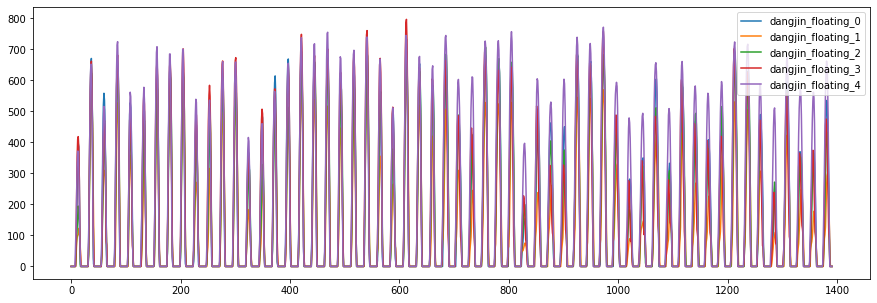

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
plt.figure(figsize=(15, 5))
m = 'dangjin_floating'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

### 에측

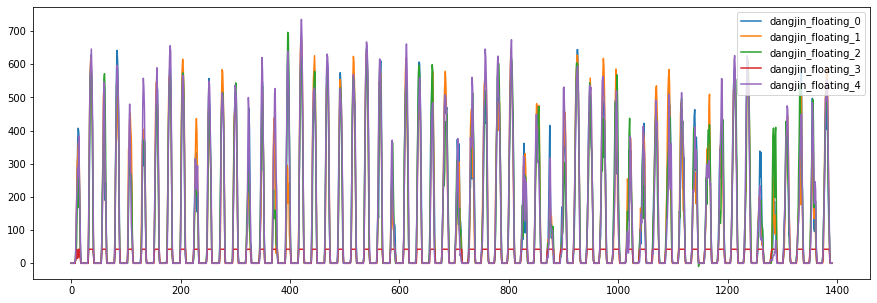

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'
plt.figure(figsize=(15, 5))
m = 'dangjin_floating'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

preds = []
m = 'dangjin_floating'

for i in range(5):
  if i == 3: pass
  else:
    model = set_model()
    model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
    pred = model.predict(X_test)
    preds.append(pred)

dangjin_floating_pred = np.mean(preds, axis=0)

In [ ]:
len(preds)

4

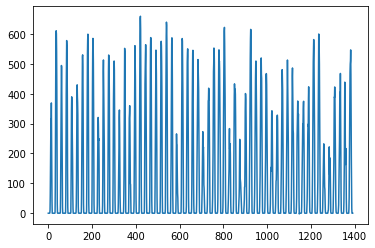

In [ ]:
plt.plot(dangjin_floating_pred)

## dangjin_warehouse

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_warehouse_df, 'dangjin_warehouse')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 학습

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
m = 'dangjin_warehouse'
BATCH_SIZE = 128
EPOCHS = 2
capacity = 700

n_split = 5
kfold = KFold(n_splits = n_split, shuffle=True, random_state=22)

accuracy = []
losss=[]

for i, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  train_X, val_X = X_train[train_idx], X_train[val_idx]
  train_y, val_y = y_train[train_idx], y_train[val_idx]
  
  model = set_model()
  mc = ModelCheckpoint(PATHS + m + f'_cv_study{i + 1}.h5', save_best_only=True, verbose=0, monitor = 'val_my_metric', mode = 'min', save_weights_only=True)
  reLR = ReduceLROnPlateau(monitor = 'val_my_metric', patience = 7,verbose = 1,factor = 0.5)

  history = model.fit(train_X, train_y, epochs = EPOCHS, validation_data = (val_X, val_y),
            verbose=1, batch_size=BATCH_SIZE, callbacks = [mc, reLR])
  
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  
  k_accuracy = '%.4f' % (model.evaluate(val_X, val_y)[1])
  k_loss = '%.4f' % (model.evaluate(val_X, val_y)[0])

  accuracy.append(k_accuracy)
  losss.append(k_loss)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

Epoch 1/2
225/225 [==============================] - 12s 41ms/step - loss: 37.7787 - my_metric: 12.8340 - val_loss: 76.8823 - val_my_metric: 25.9203
Epoch 2/2
225/225 [==============================] - 1s 6ms/step - loss: 31.9877 - my_metric: 10.7226
Epoch 1/2
225/225 [==============================] - 11s 38ms/step - loss: 37.2145 - my_metric: 12.6188 - val_loss: 33.1146 - val_my_metric: 11.3937
Epoch 2/2
225/225 [==============================] - 1s 6ms/step - loss: 35.2127 - my_metric: 10.9144
Epoch 1/2
225/225 [==============================] - 11s 38ms/step - loss: 37.9715 - my_metric: 12.8190 - val_loss: 29.6347 - val_my_metric: 11.3239
Epoch 2/2
225/225 [==============================] - 1s 7ms/step - loss: 27.6258 - my_metric: 10.0008
Epoch 1/2
225/225 [==============================] - 11s 37ms/step - loss: 38.8479 - my_metric: 13.0740 - val_loss: 35.7156 - val_my_metric: 10.8277
Epoch 2/2
225/225 [==============================] - 1s 6ms/step - loss: 26.3057 - my_metric: 9.25

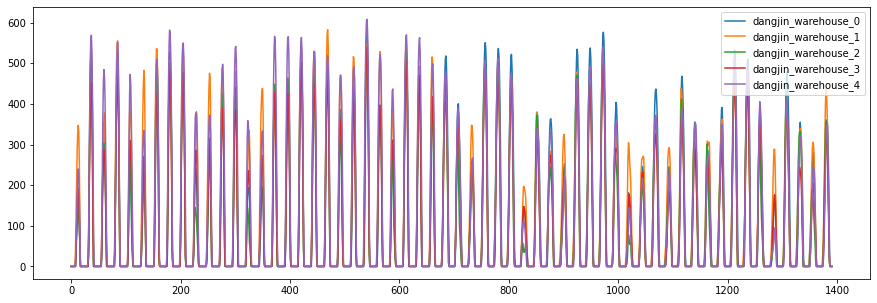

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
plt.figure(figsize=(15, 5))
m = 'dangjin_warehouse'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

### 에측

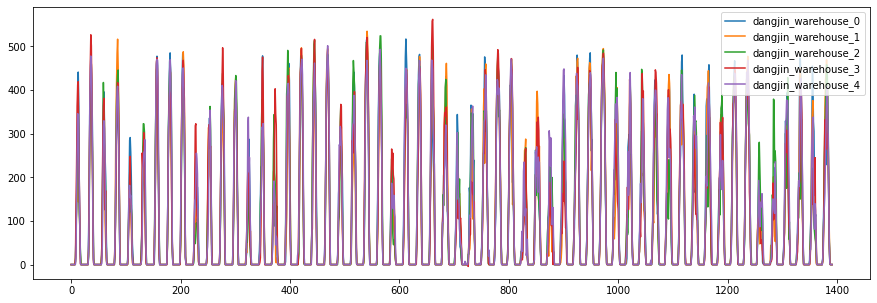

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'
plt.figure(figsize=(15, 5))
m = 'dangjin_warehouse'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

preds = []
m = 'dangjin_warehouse'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  preds.append(pred)

dangjin_warehouse_pred = np.mean(preds, axis=0)

In [ ]:
len(preds)

5

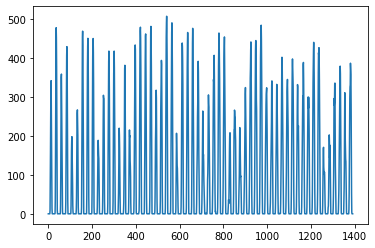

In [ ]:
plt.plot(dangjin_warehouse_pred)

## dangjin

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(dangjin_df, 'dangjin')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 학습

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
m = 'dangjin'
BATCH_SIZE = 128
EPOCHS = 2
capacity = 1000

n_split = 5
kfold = KFold(n_splits = n_split, shuffle=True, random_state=22)

accuracy = []
losss=[]

for i, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  train_X, val_X = X_train[train_idx], X_train[val_idx]
  train_y, val_y = y_train[train_idx], y_train[val_idx]
  
  model = set_model()
  mc = ModelCheckpoint(PATHS + m + f'_cv_study{i + 1}.h5', save_best_only=True, verbose=0, monitor = 'val_my_metric', mode = 'min', save_weights_only=True)
  reLR = ReduceLROnPlateau(monitor = 'val_my_metric', patience = 7,verbose = 1,factor = 0.5)

  history = model.fit(train_X, train_y, epochs = EPOCHS, validation_data = (val_X, val_y),
            verbose=1, batch_size=BATCH_SIZE, callbacks = [mc, reLR])
  
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  
  k_accuracy = '%.4f' % (model.evaluate(val_X, val_y)[1])
  k_loss = '%.4f' % (model.evaluate(val_X, val_y)[0])

  accuracy.append(k_accuracy)
  losss.append(k_loss)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

Epoch 1/2
227/227 [==============================] - 12s 41ms/step - loss: 57.9676 - my_metric: 13.5270 - val_loss: 67.9721 - val_my_metric: 16.2199
Epoch 2/2
227/227 [==============================] - 1s 6ms/step - loss: 61.2714 - my_metric: 15.2246
Epoch 1/2
227/227 [==============================] - 11s 38ms/step - loss: 56.4627 - my_metric: 13.5341 - val_loss: 47.6792 - val_my_metric: 10.4419
Epoch 2/2
227/227 [==============================] - 1s 6ms/step - loss: 42.9869 - my_metric: 10.3670
Epoch 1/2
227/227 [==============================] - 11s 37ms/step - loss: 56.0643 - my_metric: 13.2643 - val_loss: 56.5165 - val_my_metric: 12.5309
Epoch 2/2
227/227 [==============================] - 1s 5ms/step - loss: 41.2308 - my_metric: 9.9593
Epoch 1/2
227/227 [==============================] - 11s 38ms/step - loss: 56.1381 - my_metric: 13.1804 - val_loss: 50.5325 - val_my_metric: 12.7139
Epoch 2/2
227/227 [==============================] - 1s 5ms/step - loss: 50.5325 - my_metric: 12.75

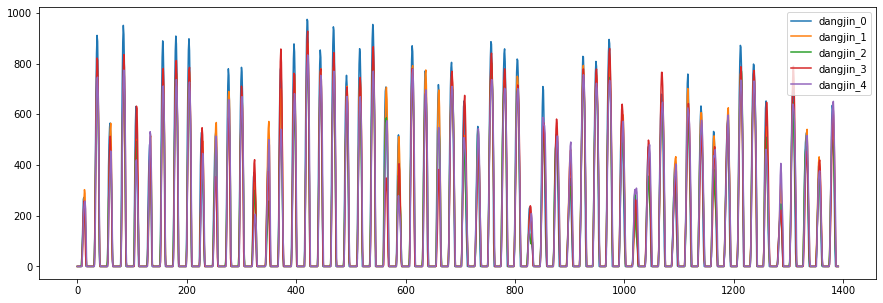

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
plt.figure(figsize=(15, 5))
m = 'dangjin'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

### 에측

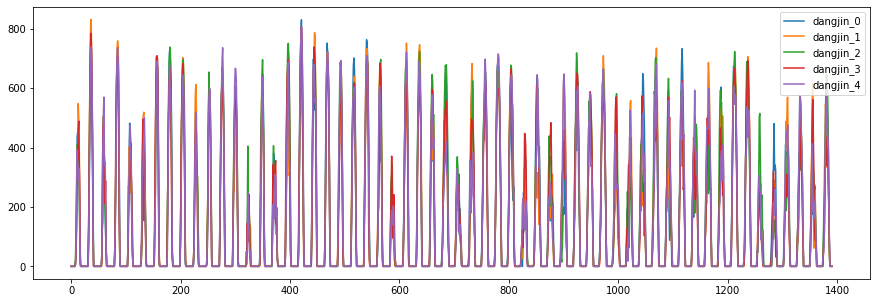

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

plt.figure(figsize=(15, 5))
m = 'dangjin'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

preds = []
m = 'dangjin'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  preds.append(pred)

dangjin_pred = np.mean(preds, axis=0)

In [ ]:
len(preds)

5

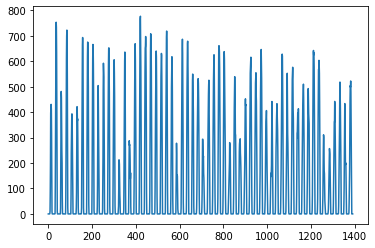

In [ ]:
plt.plot(dangjin_pred)

## ulsan

In [ ]:
X_train, y_train, Hour_train, X_publict_test, Hour_publict_test, X_private_test, Hour_private_test = get_train_val_test(ulsan_df, 'ulsan')
X_test = np.concatenate([X_publict_test, X_private_test])
Hour_test = np.concatenate([Hour_publict_test, Hour_private_test])

### 학습

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
m = 'ulsan'
BATCH_SIZE = 128
EPOCHS = 2
capacity = 500

n_split = 5
kfold = KFold(n_splits = n_split, shuffle=True, random_state=22)

accuracy = []
losss=[]

for i, (train_idx, val_idx) in enumerate(kfold.split(X_train, y_train)):
  train_X, val_X = X_train[train_idx], X_train[val_idx]
  train_y, val_y = y_train[train_idx], y_train[val_idx]
  
  model = set_model()
  mc = ModelCheckpoint(PATHS + m + f'_cv_study{i + 1}.h5', save_best_only=True, verbose=0, monitor = 'val_my_metric', mode = 'min', save_weights_only=True)
  reLR = ReduceLROnPlateau(monitor = 'val_my_metric', patience = 7,verbose = 1,factor = 0.5)

  history = model.fit(train_X, train_y, epochs = EPOCHS, validation_data = (val_X, val_y),
            verbose=1, batch_size=BATCH_SIZE, callbacks = [mc, reLR])
  
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  
  k_accuracy = '%.4f' % (model.evaluate(val_X, val_y)[1])
  k_loss = '%.4f' % (model.evaluate(val_X, val_y)[0])

  accuracy.append(k_accuracy)
  losss.append(k_loss)

print('\nK-fold cross validation Auc: {}'.format(accuracy))
print('\nK-fold cross validation loss: {}'.format(losss))

Epoch 1/2
222/222 [==============================] - 12s 43ms/step - loss: 25.3912 - my_metric: 12.2249 - val_loss: 23.2299 - val_my_metric: 10.3385
Epoch 2/2
222/222 [==============================] - 2s 7ms/step - loss: 23.2299 - my_metric: 10.4935
Epoch 1/2
222/222 [==============================] - 11s 37ms/step - loss: 26.5236 - my_metric: 12.4498 - val_loss: 20.6947 - val_my_metric: 10.4702
Epoch 2/2
222/222 [==============================] - 1s 6ms/step - loss: 21.2554 - my_metric: 9.5414
Epoch 1/2
222/222 [==============================] - 11s 38ms/step - loss: 26.5510 - my_metric: 12.2748 - val_loss: 23.6022 - val_my_metric: 12.2176
Epoch 2/2
222/222 [==============================] - 1s 6ms/step - loss: 18.3518 - my_metric: 8.9058
Epoch 1/2
222/222 [==============================] - 12s 43ms/step - loss: 24.9798 - my_metric: 11.7412 - val_loss: 22.7105 - val_my_metric: 10.1966
Epoch 2/2
222/222 [==============================] - 1s 7ms/step - loss: 22.7105 - my_metric: 10.192

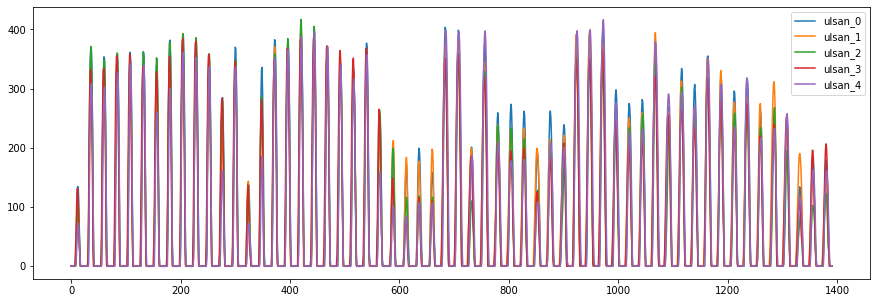

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model_V2/'
plt.figure(figsize=(15, 5))
m = 'ulsan'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

### 에측

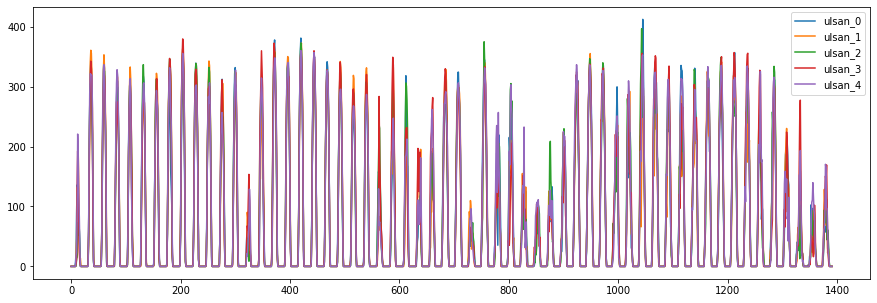

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

plt.figure(figsize=(15, 5))
m = 'ulsan'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  plt.plot(pred, label = f'{m}_{str(i)}')

plt.legend()

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Model/'

preds = []
m = 'ulsan'

for i in range(5):
  model = set_model()
  model.load_weights(PATHS + m + f'_cv_study{i + 1}.h5')
  pred = model.predict(X_test)
  preds.append(pred)

ulsan_pred = np.mean(preds, axis=0)

In [ ]:
len(preds)

5

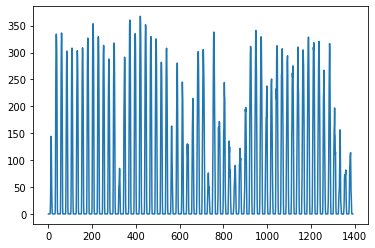

In [ ]:
plt.plot(ulsan_pred)

## 예측

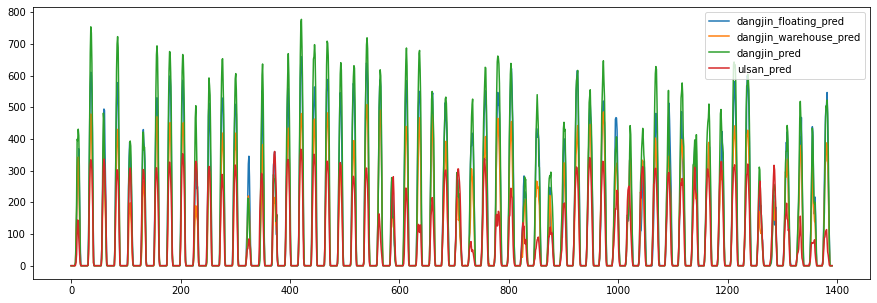

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Predict/'

submission = pd.read_csv(PATHS + 'CNN1D_0707_17_ret.csv')

In [ ]:
submission.iloc[ : , 1] = dangjin_floating_pred
submission.iloc[ : , 2] = dangjin_warehouse_pred
submission.iloc[ : , 3] = dangjin_pred
submission.iloc[ : , 4] = ulsan_pred

In [ ]:
submission.to_csv(PATHS + 'CNN1D_ret.csv', index=False)
submission.iloc[ : , :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002885,-0.000154,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002589,-0.000232,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002539,-0.000134,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002739,-0.000060,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003024,-0.000095,-0.000116,0.000045
...,...,...,...,...,...
1387,2021-07-08 20:00:00,14.803840,4.024741,0.001304,0.000045
1388,2021-07-08 21:00:00,0.002514,-0.000337,-0.000116,0.000045
1389,2021-07-08 22:00:00,0.002394,-0.000258,-0.000116,0.000045
1390,2021-07-08 23:00:00,0.002308,-0.000205,-0.000116,0.000045


# 리더보드 복원 확인

In [ ]:
PATHS = '/content/drive/MyDrive/동서발전 태양광/Predict/'

result_sub = pd.read_csv(PATHS + 'CNN1D_0707_17_ret.csv')
predict_sub = pd.read_csv(PATHS + 'CNN1D_ret.csv')

In [ ]:
result_sub.head(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002887,0.000034,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002585,-0.000061,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002537,0.000062,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002730,0.000148,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003015,0.000109,-0.000116,0.000045
5,2021-02-01 06:00:00,0.003677,0.000085,-0.000116,0.000045
6,2021-02-01 07:00:00,0.003894,-0.000076,-0.000116,0.000045
7,2021-02-01 08:00:00,0.929345,-0.000064,0.841855,0.000045
8,2021-02-01 09:00:00,10.371879,9.637656,11.320709,0.964414
9,2021-02-01 10:00:00,60.291733,85.034882,86.530907,10.746229


In [ ]:
predict_sub.head(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.002885,-0.000154,-0.000116,0.000045
1,2021-02-01 02:00:00,0.002589,-0.000232,-0.000116,0.000045
2,2021-02-01 03:00:00,0.002539,-0.000134,-0.000116,0.000045
3,2021-02-01 04:00:00,0.002739,-0.000060,-0.000116,0.000045
4,2021-02-01 05:00:00,0.003024,-0.000095,-0.000116,0.000045
5,2021-02-01 06:00:00,0.003685,-0.000115,-0.000116,0.000045
6,2021-02-01 07:00:00,0.003899,-0.000237,-0.000116,0.000045
7,2021-02-01 08:00:00,1.037492,-0.000220,0.841455,0.000045
8,2021-02-01 09:00:00,10.460457,9.211689,11.185345,1.307830
9,2021-02-01 10:00:00,60.357834,79.212715,86.234116,11.676592


In [ ]:
result_sub.iloc[(24 * 28) : (24 * 28) + 24, :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
672,2021-06-09 01:00:00,0.002611,-0.000188,-0.000116,0.000045
673,2021-06-09 02:00:00,0.005637,-0.000143,-0.000116,0.000045
674,2021-06-09 03:00:00,0.002545,-0.000123,-0.000116,0.000045
675,2021-06-09 04:00:00,0.002336,-0.000202,-0.000116,0.000045
676,2021-06-09 05:00:00,0.002540,-0.000165,-0.000116,0.000045
677,2021-06-09 06:00:00,0.962114,0.029312,2.285660,0.005207
678,2021-06-09 07:00:00,35.294762,26.703842,21.495232,25.709436
679,2021-06-09 08:00:00,115.172760,93.903305,85.089684,74.052940
680,2021-06-09 09:00:00,197.810272,124.264793,220.152802,143.657501
681,2021-06-09 10:00:00,294.817047,169.877594,311.044281,213.187592


In [ ]:
predict_sub.iloc[(24 * 28) : (24 * 28) + 24, :]

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
672,2021-06-09 01:00:00,0.002613,-0.000187,-0.000116,0.000045
673,2021-06-09 02:00:00,0.006869,-0.000142,-0.000116,0.000045
674,2021-06-09 03:00:00,0.002543,-0.000119,-0.000116,0.000045
675,2021-06-09 04:00:00,0.002333,-0.000201,-0.000116,0.000045
676,2021-06-09 05:00:00,0.002541,-0.000165,-0.000116,0.000045
677,2021-06-09 06:00:00,0.946207,0.017531,2.175927,0.004350
678,2021-06-09 07:00:00,35.362232,26.653940,21.679266,25.682043
679,2021-06-09 08:00:00,115.501244,93.915176,85.063766,73.999161
680,2021-06-09 09:00:00,197.736496,124.434692,220.042313,143.813217
681,2021-06-09 10:00:00,295.383423,170.092392,310.622986,213.515869


In [ ]:
result_sub.tail(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
1368,2021-07-08 01:00:00,0.002512,-0.000100,-0.000116,0.000045
1369,2021-07-08 02:00:00,0.002540,-0.000206,-0.000116,0.000045
1370,2021-07-08 03:00:00,0.002464,-0.000156,-0.000116,0.000045
1371,2021-07-08 04:00:00,0.002251,-0.000391,-0.000116,0.000045
1372,2021-07-08 05:00:00,0.010027,-0.000245,-0.000116,0.000045
1373,2021-07-08 06:00:00,0.002251,-0.000270,-0.000116,0.000045
1374,2021-07-08 07:00:00,14.533589,11.060273,5.540959,7.759534
1375,2021-07-08 08:00:00,51.805302,52.393780,46.703117,25.694103
1376,2021-07-08 09:00:00,152.677933,119.057739,117.144958,59.310772
1377,2021-07-08 10:00:00,240.278366,217.574539,168.118713,88.191605


In [ ]:
predict_sub.tail(24)

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
1368,2021-07-08 01:00:00,0.002512,-0.000100,-0.000116,0.000045
1369,2021-07-08 02:00:00,0.002540,-0.000206,-0.000116,0.000045
1370,2021-07-08 03:00:00,0.002464,-0.000156,-0.000116,0.000045
1371,2021-07-08 04:00:00,0.002251,-0.000391,-0.000116,0.000045
1372,2021-07-08 05:00:00,0.010028,-0.000245,-0.000116,0.000045
1373,2021-07-08 06:00:00,0.002251,-0.000270,-0.000116,0.000045
1374,2021-07-08 07:00:00,14.533606,11.060264,5.540955,7.759528
1375,2021-07-08 08:00:00,51.805313,52.393806,46.703114,25.694067
1376,2021-07-08 09:00:00,152.677979,119.057816,117.144997,59.310863
1377,2021-07-08 10:00:00,240.278397,217.574615,168.118729,88.191589
